# Taxi demand prediction

## Problem
Supply/demand information plays an important role in taxi operations. The task is to predict demand by location and time.

## Data
Data is a simplified version of [Chicago Taxi Rides 2016](https://www.kaggle.com/chicago/chicago-taxi-rides-2016). It contains only 3 months of data (January-March) and 4 columns:

**pickup_latitude** - The id code for the latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. <br>
**pickup_longitude** - The id code for the longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. <br>
**trip_start_timestamp** - When the trip started, rounded to the nearest 15 minutes.<br>
**pickup_community_area** - The Community Area where the trip began.

In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from collections import Counter

### Unzipping and loading data

In [3]:
path = r'data'
zips = glob.glob(path + "/*.zip")
for filename in zips:
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path)

In [4]:
csvs = glob.glob(path + "/*.csv")
dfs = []

for filename in csvs:
    df = pd.read_csv(filename, usecols=['pickup_latitude', 'pickup_longitude', 'trip_start_timestamp', 
                                        'pickup_community_area'], parse_dates=['trip_start_timestamp'])
    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)

### Exploratory data analysis

In [4]:
df.head()

,trip_start_timestamp,pickup_community_area,pickup_latitude,pickup_longitude
0,2016-01-13 06:15:00,24.0,199.0,510.0
1,2016-01-22 09:30:00,NaN,NaN,NaN
2,2016-01-31 21:30:00,NaN,NaN,NaN
3,2016-01-23 17:30:00,6.0,686.0,500.0
4,2016-01-14 05:45:00,32.0,385.0,478.0


In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432105 entries, 0 to 5432104
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trip_start_timestamp   5432105 non-null  datetime64[ns]
 1   pickup_community_area  4512556 non-null  float64       
 2   pickup_latitude        4512639 non-null  float64       
 3   pickup_longitude       4512639 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 165.8 MB


In [7]:
df.isnull().sum()

trip_start_timestamp          0
pickup_community_area    919549
pickup_latitude          919466
pickup_longitude         919466
dtype: int64

As you can see we have more than 900.000 of rows without pickup location information. Let's drop them for our simple model. But ideally we need to take them into account (because they will affect the demand) and maybe try to distribute them proportionally among pickup locations.

In [5]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df['pickup_latitude'] = df['pickup_latitude'].astype(int)
df['pickup_longitude'] = df['pickup_longitude'].astype(int)
df['pickup_community_area'] = df['pickup_community_area'].astype(int)

Let's take a look at community areas and pickup locations.

In [7]:
n_community_areas = len(df['pickup_community_area'].unique())
print(f'Number of community areas: {n_community_areas}')

Number of community areas: 77


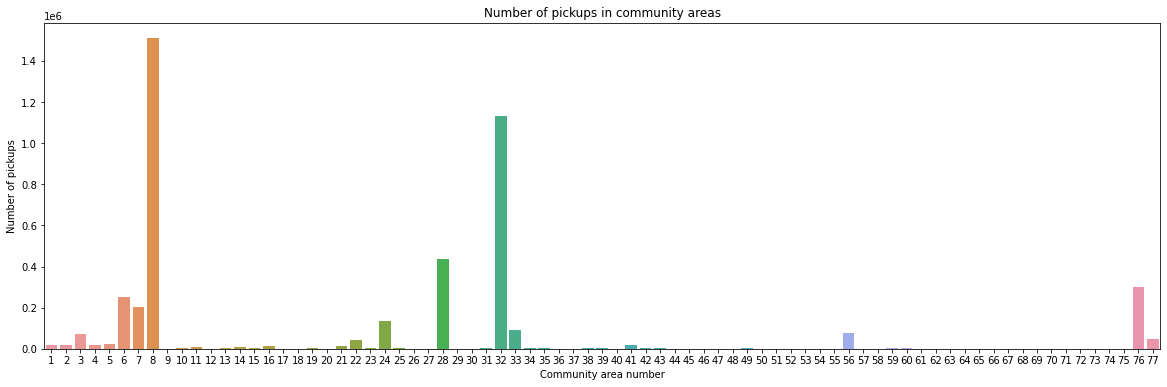

In [28]:
plt.figure(figsize=(20,6))
sns.countplot(data=df, x='pickup_community_area')
plt.title('Number of pickups in community areas')
plt.xlabel('Community area number')
plt.ylabel('Number of pickups')
plt.show()

There are only a couple of pickup community areas, that are much more popular than the others.

In [44]:
df['pickup_community_area'].value_counts()[:5].sum()/len(df)

0.805052169989691

5 most pupular pickup community areas have more than 80% of all pickups.

Pickup latitude and pickup longitude in this dataset are not the real location, but just ids of centers of the pickup census tracts. Let's see how many unique pickup locations are there.
Also let's create mapping of every pickup location to integrer id that is larger if location is more popular.

In [8]:
pickup_locations = list(zip(df['pickup_latitude'], df['pickup_longitude']))
counter = Counter(pickup_locations)
unique_pickup_locations = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1])}
map_locations = dict(zip(unique_pickup_locations.keys(), range(len(unique_pickup_locations))))
print(f'Number of pickup locations: {len(unique_pickup_locations)}')

Number of pickup locations: 436


### Feature engineering
Extracting day, month and day of week from trip_start_timestamp.

In [11]:
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['day'] = df['trip_start_timestamp'].dt.day
df['month'] = df['trip_start_timestamp'].dt.month

Creating feature pickup location.

In [12]:
df['pickup_location'] = pd.Series(pickup_locations).map(map_locations)

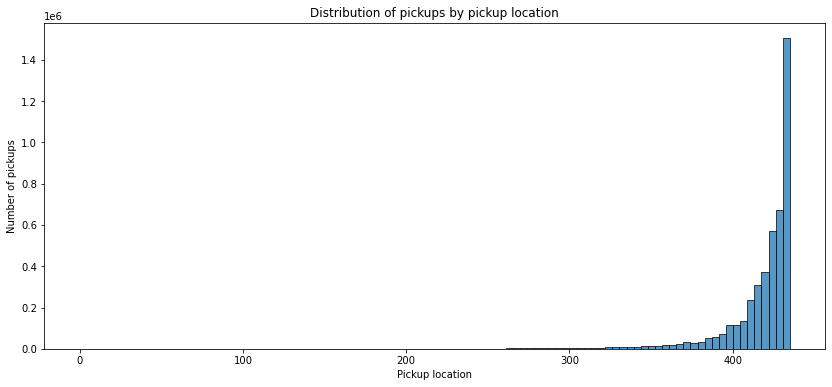

In [45]:
plt.figure(figsize=(14,6))
sns.histplot(data=df, x='pickup_location', bins=100)
plt.title('Distribution of pickups by pickup location')
plt.xlabel('Pickup location')
plt.ylabel('Number of pickups')
plt.show()

Creating feature *time bin*, that attributes every trip_start_timestamp to a time interval of 30 minutes and assigns it an integer id (larger is later).

In [13]:
times = np.sort(df['trip_start_timestamp'].dt.floor('30min').dt.time.unique())
time_map = dict(zip(times, range(len(times))))
df['time_bin'] = df['trip_start_timestamp'].dt.floor('30min').dt.time.map(time_map)

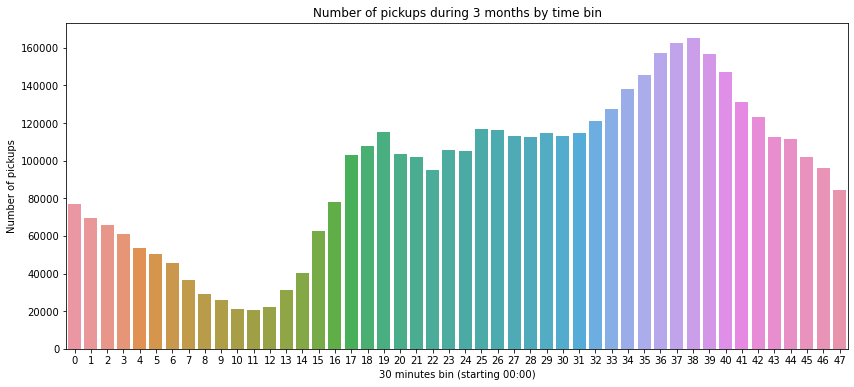

In [29]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='time_bin', )
plt.title('Number of pickups during 3 months by time bin')
plt.xlabel('30 minutes bin (starting 00:00)')
plt.ylabel('Number of pickups')
plt.show()

#### Features to consider for better model
1. Is it a public holiday today?
2. Weather coditions (i.e. general weather condition, temperature, amount of precipitation during last hour)
3. Traffic
4. Public events nearby

Dropping several columns that we won't need anymore.

In [15]:
df.drop(columns=['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude'], inplace=True)

Counting number of pickups for every pickup location for every day and time bin.

In [16]:
ndf = df.value_counts(subset=['pickup_location', 'pickup_community_area', 'month', 'day', 
                                  'time_bin', 'day_of_week']).to_frame('orders').reset_index()

In [17]:
ndf.head()

,pickup_location,pickup_community_area,month,day,time_bin,day_of_week,orders
0,435,32,3,23,36,2,552
1,435,32,2,2,35,1,545
2,435,32,2,10,36,2,543
3,435,32,2,11,36,3,533
4,435,32,2,2,34,1,529


Dropping month and day as we only have 3 months of data and we are going with general model.

In [18]:
ndf.drop(columns=['month', 'day'], inplace=True)

Let's take a look at how our features are corellated to demand.

In [19]:
ndf.corr()['orders']

pickup_location          0.378684
pickup_community_area    0.035317
time_bin                 0.100171
day_of_week             -0.035281
orders                   1.000000
Name: orders, dtype: float64

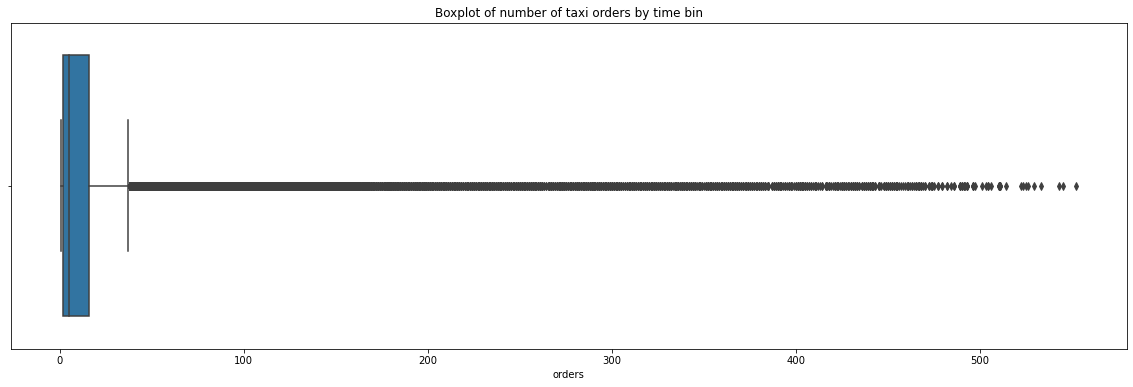

In [20]:
plt.figure(figsize=(20,6))
plt.title('Boxplot of number of taxi orders by time bin')
sns.boxplot(x='orders', data=ndf)
plt.show()

We have a lot of outliers. So there are some time intervals where number of pickups is much higher, than in most of intervals.

### Model building
Splitting dataset into train and test.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(ndf.drop(columns=['orders']), ndf['orders'], 
                                                    test_size=0.3, random_state=42)

Let's try several different models without tuning and compare them. We'er gonna use MSE as we have lots of outliers.

In [22]:
rf = RandomForestRegressor(n_jobs=-1, random_state=1)
gb = GradientBoostingRegressor(random_state=1)
lr = LinearRegression()

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
lr.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
lr_pred = lr.predict(X_test)

In [23]:
predictions = [rf_pred, gb_pred, lr_pred]
mse = []
for pred in predictions:
    mse.append(mean_squared_error(y_test, pred))

In [24]:
pd.DataFrame({'Model': ['Random Forrest', 'Gradient Boosting', 'Linear Regression'], 'MSE': mse})

,Model,MSE
0,Random Forrest,63.649554
1,Gradient Boosting,150.641892
2,Linear Regression,751.995338


As you can see Random Forrest perfoms better, so we are gonna go with it. And let's take a look at coefficient of determination ($R^2$) of the random forrest prediction.

In [25]:
r2 = rf.score(X_test, y_test)
print(f'R^2: {r2}')

R^2: 0.9288694585003493


Ideally we should fine tune the model with the help of GridSearchCV. But in our case I won't waste time on it because it will require some. And I'm not sure it will give us substential growth in accuracy.

In [118]:
# params = {'max_depth': [range(10, 101, 10)],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [int(x) for x in np.linspace(50, 1000, 5)]}

# grid = GridSearchCV(rf, params, n_jobs=-1)
# grid.fit(X_train, y_train)

### Saving model

In [26]:
with open('models/model.pkl', 'wb+') as file:
    joblib.dump(rf, file, compress=3)

Also we will need pickup location, community area and time bins dictionaries.

In [27]:
with open('models/locations.pkl', 'wb+') as file:
    pickle.dump(map_locations, file)
    
with open('models/time.pkl', 'wb+') as file:
    pickle.dump(time_map, file)
    
area_df = ndf[['pickup_location', 'pickup_community_area']].drop_duplicates(subset=['pickup_location'])
map_area = dict(zip(area_df['pickup_location'], area_df['pickup_community_area']))
with open('models/area.pkl', 'wb+') as file:
    pickle.dump(map_area, file) 